
# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint

## Learning Objective

At the end of the experiment, you will be able to:

* Understand how to implement MLP using PyTorch to run on GPU


In [0]:
#@title Experiment Explanation Video
from IPython.display import HTML

HTML("""<video width="800" height="300" controls>
  <source src="https://cdn.talentsprint.com/aiml/AIML_BATCH_HYD_7/3March/mlp_wIthpytorch.mp4" type="video/mp4">
</video>
""")

## Dataset



### Description


1. The dataset contains 60,000 Handwritten digits as training samples and 10,000 Test samples, 
which means each digit occurs 6000 times in the training set and 1000 times in the testing set. (approximately). 
2. Each image is Size Normalized and Centered 
3. Each image is 28 X 28 Pixel with 0-255 Gray Scale Value. 
4. That means each image is represented as 784 (28 X28) dimension vector where each value is in the range 0- 255.


### History

Yann LeCun (Director of AI Research, Facebook, Courant Institute, NYU) was given the task of identifying the cheque numbers (in the 90’s) and the amount associated with that cheque without manual intervention. That is when this dataset was created which raised the bars and became a benchmark.

Yann LeCun and Corinna Cortes (Google Labs, New York) hold the copyright of MNIST dataset, which is a subset of the original NIST datasets. This dataset is made available under the terms of the Creative Commons Attribution-Share Alike 3.0 license. 

It is the handwritten digits dataset in which half of them are written by the Census Bureau employees and remaining by the high school students. The digits collected among the Census Bureau employees are easier and cleaner to recognize than the digits collected among the students.

## Domain Information



Handwriting changes person to person. Some of us have neat handwriting and some have illegible handwriting such as doctors. However, if you think about it even a child who recognizes alphabets and numerics can identify the characters of a text even written by a stranger. But even a technically knowledgeable adult cannot describe the process by which he or she recognizes the text/letters. As you know this is an excellent challenge for Machine Learning.

![altxt](https://i.pinimg.com/originals/f2/7a/ac/f27aac4542c0090872110836d65f4c99.jpg)

The experiment handles a subset of text recognition, namely recognizing the 10 numerals (0 to 9) from scanned images.


#### In this experiment we will be performing the following steps:

    1. Initialize CUDA
    2. Load MNIST dataset, and visualize
    3. Define the Neural Network and optimizer
    4. Train the model

### Setup Steps

In [0]:
#@title Please enter your registration id to start: (e.g. P181900101) { run: "auto", display-mode: "form" }
Id = "P181902118" #@param {type:"string"}


In [0]:
#@title Please enter your password (normally your phone number) to continue: { run: "auto", display-mode: "form" }
password = "8860303743" #@param {type:"string"}


In [3]:
#@title Run this cell to complete the setup for this Notebook

from IPython import get_ipython
ipython = get_ipython()
  
notebook="BLR_M2W2E22_MLP_Pytorch" #name of the notebook
def setup():
    ipython.magic("sx pip3 install torch")
    ipython.magic("sx pip3 install torchvision")
    ipython.magic("sx pip3 install seaborn")
    print ("Setup completed successfully")
    return

def submit_notebook():
    
    ipython.magic("notebook -e "+ notebook + ".ipynb")
    
    import requests, json, base64, datetime

    url = "https://dashboard.talentsprint.com/xp/app/save_notebook_attempts"
    if not submission_id:
      data = {"id" : getId(), "notebook" : notebook, "mobile" : getPassword()}
      r = requests.post(url, data = data)
      r = json.loads(r.text)

      if r["status"] == "Success":
          return r["record_id"]
      elif "err" in r:        
        print(r["err"])
        return None        
      else:
        print ("Something is wrong, the notebook will not be submitted for grading")
        return None

    elif getAnswer() and getComplexity() and getAdditional() and getConcepts():
      f = open(notebook + ".ipynb", "rb")
      file_hash = base64.b64encode(f.read())

      data = {"complexity" : Complexity, "additional" :Additional, 
              "concepts" : Concepts, "record_id" : submission_id, 
              "answer" : Answer, "id" : Id, "file_hash" : file_hash,
              "notebook" : notebook}

      r = requests.post(url, data = data)
      r = json.loads(r.text)
      print("Your submission is successful.")
      print("Ref Id:", submission_id)
      print("Date of submission: ", r["date"])
      print("Time of submission: ", r["time"])
      print("View your submissions: https://iiith-aiml.talentsprint.com/notebook_submissions")
      print("For any queries/discrepancies, please connect with mentors through the chat icon in LMS dashboard.")
      return submission_id
    else: submission_id
    

def getAdditional():
  try:
    if Additional: return Additional      
    else: raise NameError('')
  except NameError:
    print ("Please answer Additional Question")
    return None

def getComplexity():
  try:
    return Complexity
  except NameError:
    print ("Please answer Complexity Question")
    return None
  
def getConcepts():
  try:
    return Concepts
  except NameError:
    print ("Please answer Concepts Question")
    return None

def getAnswer():
  try:
    return Answer
  except NameError:
    print ("Please answer Question")
    return None

def getId():
  try: 
    return Id if Id else None
  except NameError:
    return None

def getPassword():
  try:
    return password if password else None
  except NameError:
    return None

submission_id = None
### Setup 
if getPassword() and getId():
  submission_id = submit_notebook()
  if submission_id:
    setup()
  
else:
  print ("Please complete Id and Password cells before running setup")



Setup completed successfully


In [0]:
## Importing required packages
%matplotlib inline

### Importing torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Importing python packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### 1. Initializing CUDA

CUDA is used as an interface between our code and the GPU.

Normally, we run the code in the CPU. To run it in the GPU, we need CUDA. Check if CUDA is available:

In [5]:
### To test whether GPU instance is present in the system of not.
use_cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', use_cuda)

Using PyTorch version: 1.0.1.post2 CUDA: True


In [6]:
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

If it's False, then we run the program on CPU. If it's True, then we run the program on GPU.

Let us initialize some GPU-related variables:

In [0]:
### Initializing batch size
batch_size = 32

#### 2. Load MNIST data

Now, we'll load the MNIST data. For the first time, we may have to download the data, which can take a while.

In [0]:
## Loading the train set file
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, 
    #**kwargs
    )

## Loading the test set file
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, 
    #**kwargs
    )

The train and test data are provided via data loaders that provide iterators over the datasets.

The first element of training data (X_train) is a 4th-order tensor of size (batch_size, 1, 28, 28), i.e. it consists of a batch of images of size 1x28x28 pixels. y_train is a vector containing the correct classes ("0", "1", ..., "9") for each training digit.

In [11]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


#### Plotting the  first 10 training digits

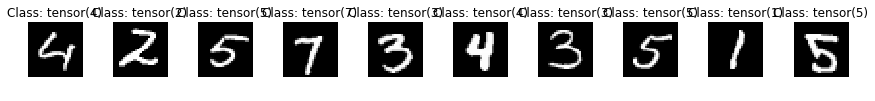

In [12]:
pltsize=1
plt.figure(figsize=(15*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray")
    plt.title('Class: '+str(y_train[i]))

#### 3. Define the neural network and optimizer

Let's define the network as a Python class.

As we know from the previous experiment, we have to write the **\__init__()** and **forward()** methods, and PyTorch will automatically generate a **backward()** method for computing the gradients for the backward pass.

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 50)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))#Why do we sometimes use F. and sometimes nn.? You could refere the following link: https://discuss.pytorch.org/t/whats-the-difference-between-nn-relu-vs-f-relu/27599
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), dim=1)

Let us declare an object of class Net, and make it a CUDA model if CUDA is available:

In [14]:
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net()
model = model.to(device)

cuda


In [15]:
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.2)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc2_drop): Dropout(p=0.2)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)


Finally, we define an optimizer to update the model parameters based on the computed gradients. We select stochastic gradient descent (with momentum) as the optimization algorithm, and set learning rate to 0.01. Note that there are several different options for the optimizer in PyTorch that we could use instead of SGD.

Let us define the Optimizer as SGD:

In [0]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

#### 4. Train the model
Let's now define functions to train() and test() the model.

In [0]:
def train(epoch, log_interval=100):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
       
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

Now we are ready to train our model using the train() function. An epoch means one pass through the whole training data. After each epoch, we evaluate the model using test():

In [0]:
def test(loss_vector, accuracy_vector):
    model.eval()
    test_loss, correct = 0, 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += F.nll_loss(output, target).item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).to(device).sum()

    test_loss /= len(test_loader)
    loss_vector.append(test_loss)

    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

Let us compute the time it takes to run this, so as to compare the GPU's performance time with that of CPU.

In [19]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs +
                   1):
    train(epoch)
    test(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.333297
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.603229
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.902751
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.744700
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.487384
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.359854
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.756474
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.294483
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.461067
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.434813
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.539880
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.445927
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.160426
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.222411
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.359105
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.438053
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.337344
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.252004
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.433226

Test set: Average loss: 0.2239, Accuracy: 9314/10000 (93%)

Thus, GPU is much faster!

Let's now visualize how the training progressed.

Loss is a function of the difference of the network output and the target values. We are minimizing the loss function during training so it should decrease over time.

Text(0, 0.5, 'error')

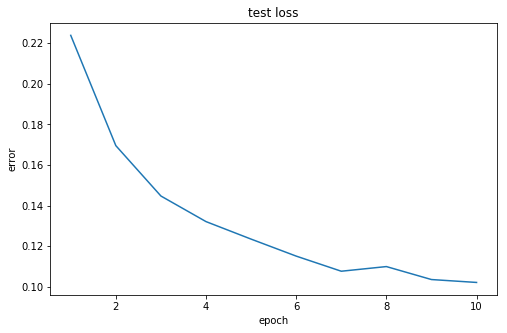

In [20]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('test loss')
plt.xlabel("epoch")
plt.ylabel("error")

#### Ungraded Exercise 1: 

Plot the graph for test accuracy

Text(0, 0.5, 'accuracy')

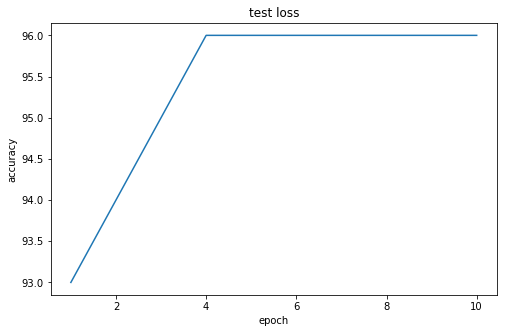

In [21]:
# Your Code Here

plt.figure(figsize=(8,5))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('test loss')
plt.xlabel("epoch")
plt.ylabel("accuracy")

#### Ungraded Exercise 2:
 
Change the number of epoch to 5. Calculate the accuracy for both training and testing data.

In [22]:
# Your Code Here

%%time
epochs = 5

lossv, accv = [], []
for epoch in range(1, epochs +
                   1):
    train(epoch)
    test(lossv, accv)


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.039669
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.155771
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.200573
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.141717
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.190805
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.074111
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.172093
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.283623
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.163401
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.088694
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.156674
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.175827
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.024943
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.025845
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.022991
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.087425
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.197885
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.120757
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.106053

Test set: Average loss: 0.0993, Accuracy: 9711/10000 (97%)

In [27]:
print("test accuracy =", accv[-1])

test accuracy = tensor(97, device='cuda:0')


### Please answer the questions below to complete the experiment:




In [0]:
#@title optimzer.step() (used in the code above) computes the gradients of Loss w.r.t weights? { run: "auto", form-width: "500px", display-mode: "form" }
Answer = "FALSE" #@param ["TRUE","FALSE"]


In [0]:
#@title How was the experiment? { run: "auto", form-width: "500px", display-mode: "form" }
Complexity = "Good and Challenging me" #@param ["Too Simple, I am wasting time", "Good, But Not Challenging for me", "Good and Challenging me", "Was Tough, but I did it", "Too Difficult for me"]


In [0]:
#@title If it was very easy, what more you would have liked to have been added? If it was very difficult, what would you have liked to have been removed? { run: "auto", display-mode: "form" }
Additional = " test" #@param {type:"string"}

In [0]:
#@title Can you identify the concepts from the lecture which this experiment covered? { run: "auto", vertical-output: true, display-mode: "form" }
Concepts = "Yes" #@param ["Yes", "No"]

In [28]:
#@title Run this cell to submit your notebook for grading { vertical-output: true }
try:
  if submission_id:
      return_id = submit_notebook()
      if return_id : submission_id =return_id
  else:
      print("Please complete the setup first.")
except NameError:
  print ("Please complete the setup first.")

Your submission is successful.
Ref Id: 4521
Date of submission:  02 May 2019
Time of submission:  22:28:04
View your submissions: https://iiith-aiml.talentsprint.com/notebook_submissions
For any queries/discrepancies, please connect with mentors through the chat icon in LMS dashboard.
